In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import os
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

In [2]:
train = pd.read_csv('/Users/kassandramadulka/Downloads/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('/Users/kassandramadulka/Downloads/store-sales-time-series-forecasting/test.csv')
sample_submission = pd.read_csv('/Users/kassandramadulka/Downloads/store-sales-time-series-forecasting/sample_submission.csv')
transactions = pd.read_csv('/Users/kassandramadulka/Downloads/store-sales-time-series-forecasting/transactions.csv')
oil = pd.read_csv('/Users/kassandramadulka/Downloads/store-sales-time-series-forecasting/oil.csv')
holidays_events = pd.read_csv('/Users/kassandramadulka/Downloads/store-sales-time-series-forecasting/holidays_events.csv')
stores = pd.read_csv('/Users/kassandramadulka/Downloads/store-sales-time-series-forecasting/stores.csv')

train.head(20)

id        date  store_nbr               family  sales  onpromotion
0    0  2013-01-01          1           AUTOMOTIVE    0.0            0
1    1  2013-01-01          1            BABY CARE    0.0            0
2    2  2013-01-01          1               BEAUTY    0.0            0
3    3  2013-01-01          1            BEVERAGES    0.0            0
4    4  2013-01-01          1                BOOKS    0.0            0
5    5  2013-01-01          1         BREAD/BAKERY    0.0            0
6    6  2013-01-01          1          CELEBRATION    0.0            0
7    7  2013-01-01          1             CLEANING    0.0            0
8    8  2013-01-01          1                DAIRY    0.0            0
9    9  2013-01-01          1                 DELI    0.0            0
10  10  2013-01-01          1                 EGGS    0.0            0
11  11  2013-01-01          1         FROZEN FOODS    0.0            0
12  12  2013-01-01          1            GROCERY I    0.0            0
13  13  2013-01-01          1           GROCERY II    0.0            0
14  14  2013-01-01          1             HARDWARE    0.0            0
15  15  2013-01-01          1   HOME AND KITCHEN I    0.0            0
16  16  2013-01-01          1  HOME AND KITCHEN II    0.0            0
17  17  2013-01-01          1      HOME APPLIANCES    0.0            0
18  18  2013-01-01          1            HOME CARE    0.0            0
19  19  2013-01-01          1           LADIESWEAR    0.0            0

In [4]:
# check if any na values
print(train.shape)
print(train.dropna().shape)

(3000888, 6)
(3000888, 6)


## Exploratory

In [9]:
# format dates
store_sales = pd.read_csv(
    '/Users/kassandramadulka/Downloads/store-sales-time-series-forecasting/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales['date'] = store_sales.date.dt.to_period('D')
# forecast sales by family and store number - reindex
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales.head()

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

In [21]:
# format dates for test data

# Test data: test.csv
store_sales_test = pd.read_csv(
    '/Users/kassandramadulka/Downloads/store-sales-time-series-forecasting/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales_test['date'] = store_sales_test.date.dt.to_period('D')
# forecast sales by family and store number - reindex
store_sales_test = store_sales_test.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales_test.head()

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0

In [196]:
# holiday data
holiday_events = pd.read_csv(
    "/Users/kassandramadulka/Downloads/store-sales-time-series-forecasting/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holiday_events.set_index('date').to_period('D')

holidays_events.head()

type    locale locale_name                    description  \
date                                                                       
2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

            transferred  
date                     
2012-03-02        False  
2012-04-01        False  
2012-04-12        False  
2012-04-14        False  
2012-04-21        False

In [22]:
# see date range
print(store_sales.index.get_level_values(2).min())
print(store_sales.index.get_level_values(2).max())
print(store_sales_test.index.get_level_values(2).min())
print(store_sales_test.index.get_level_values(2).max())

2013-01-01
2017-08-15
2017-08-16
2017-08-31


In [25]:
# see number of families
print(store_sales.index.get_level_values(1).unique())
print(len(store_sales.index.get_level_values(1).unique()))

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, name='family', dtype='category')
33


In [26]:
# see number of stores
print(store_sales.index.get_level_values(0).unique())
print(len(store_sales.index.get_level_values(0).unique()))

CategoricalIndex(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
                  '19', '2', '20', '21', '22', '23', '24', '25', '26', '27',
                  '28', '29', '3', '30', '31', '32', '33', '34', '35', '36',
                  '37', '38', '39', '4', '40', '41', '42', '43', '44', '45',
                  '46', '47', '48', '49', '5', '50', '51', '52', '53', '54',
                  '6', '7', '8', '9'],
                 categories=['1', '10', '11', '12', '13', '14', '15', '16', ...], ordered=False, name='store_nbr', dtype='category')
54


<AxesSubplot:xlabel='date'>

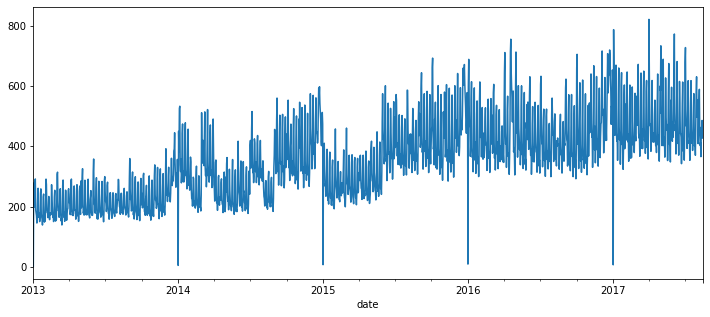

In [31]:
# trend in sales

average_sales = store_sales['sales'].groupby('date').mean()
average_sales.plot(figsize=(12,5))

In [34]:
average_sales

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
                 ...    
2017-08-11    463.733856
2017-08-12    444.798279
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 1684, dtype: float32

<AxesSubplot:xlabel='date'>

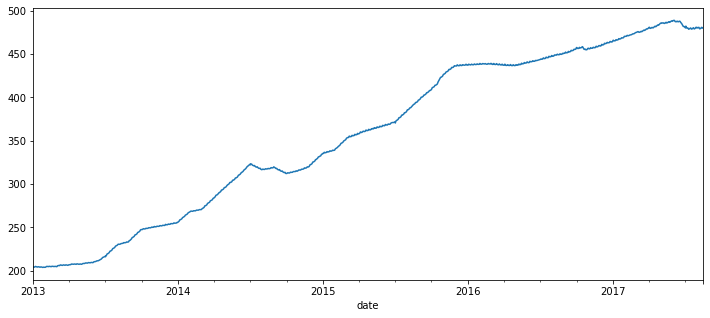

In [35]:
# rolling mean - see overall increase over time

rolling_avg = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

rolling_avg.plot(figsize=(12,5))

In [48]:
# note I took the code for these graphs from learntools on github - this is not my own
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

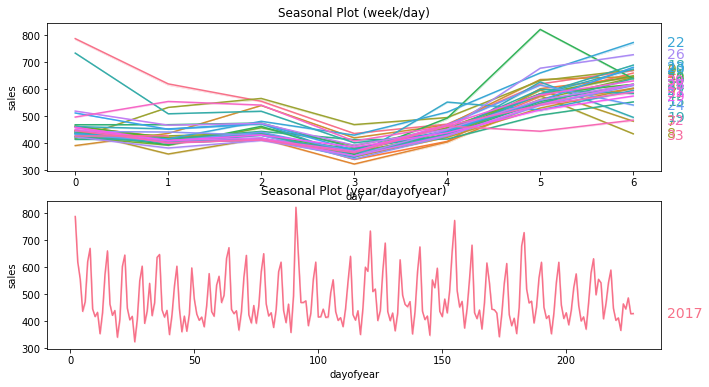

In [55]:
# look for seasonal trends

store_sales["day"] = store_sales.index.get_level_values(2).dayofweek  
store_sales["week"] = store_sales.index.get_level_values(2).week 

# days within a year
store_sales["dayofyear"] = store_sales.index.get_level_values(2).dayofyear
store_sales["year"] = store_sales.index.get_level_values(2).year

# graph periodigram
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
# only look at 1 year because all data was taking too long
one_year_data = store_sales[store_sales.index.get_level_values(2)>'2017']
seasonal_plot(one_year_data, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(one_year_data, y="sales", period="year", freq="dayofyear", ax=ax1);


<ipython-input-56-aadf2c08896c>:2: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  plot_periodogram(one_year_data['sales'].groupby('date').mean())


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

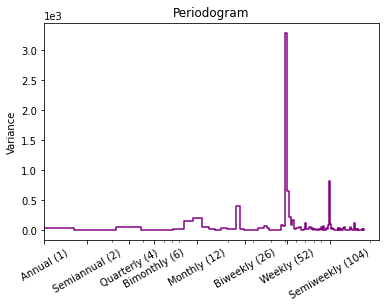

In [56]:
# periodigram
plot_periodogram(one_year_data['sales'].groupby('date').mean())

In [76]:
# create deterministic process
# we see weekly/biweekly trends based on the plot so can create a Fourier series

# Fourier features
weekly_trend = CalendarFourier(freq='M', order=4)

det_model = DeterministicProcess(
    index = store_sales.index.get_level_values(2).unique(),
    constant = True,
    order=3,
    seasonal=True, # for weekday seasonality
    additional_terms=[weekly_trend],
    drop=True, # avoid colinearity according to documentation
)

det_model.in_sample()

# add holidays as dummy variable


const   trend  trend_squared   trend_cubed  s(2,7)  s(3,7)  \
date                                                                     
2013-01-01    1.0     1.0            1.0  1.000000e+00     0.0     0.0   
2013-01-02    1.0     2.0            4.0  8.000000e+00     1.0     0.0   
2013-01-03    1.0     3.0            9.0  2.700000e+01     0.0     1.0   
2013-01-04    1.0     4.0           16.0  6.400000e+01     0.0     0.0   
2013-01-05    1.0     5.0           25.0  1.250000e+02     0.0     0.0   
...           ...     ...            ...           ...     ...     ...   
2017-08-11    1.0  1680.0      2822400.0  4.741632e+09     0.0     0.0   
2017-08-12    1.0  1681.0      2825761.0  4.750104e+09     0.0     0.0   
2017-08-13    1.0  1682.0      2829124.0  4.758587e+09     1.0     0.0   
2017-08-14    1.0  1683.0      2832489.0  4.767079e+09     0.0     1.0   
2017-08-15    1.0  1684.0      2835856.0  4.775582e+09     0.0     0.0   

            s(4,7)  s(5,7)  s(6,7)  s(7,7)  sin(1,freq=M)  cos(1,freq=M)  \
date                                                                       
2013-01-01     0.0     0.0     0.0     0.0       0.000000       1.000000   
2013-01-02     0.0     0.0     0.0     0.0       0.201299       0.979530   
2013-01-03     0.0     0.0     0.0     0.0       0.394356       0.918958   
2013-01-04     1.0     0.0     0.0     0.0       0.571268       0.820763   
2013-01-05     0.0     1.0     0.0     0.0       0.724793       0.688967   
...            ...     ...     ...     ...            ...            ...   
2017-08-11     0.0     0.0     0.0     1.0       0.897805      -0.440394   
2017-08-12     0.0     0.0     0.0     0.0       0.790776      -0.612106   
2017-08-13     0.0     0.0     0.0     0.0       0.651372      -0.758758   
2017-08-14     0.0     0.0     0.0     0.0       0.485302      -0.874347   
2017-08-15     1.0     0.0     0.0     0.0       0.299363      -0.954139   

            sin(2,freq=M)  cos(2,freq=M)  sin(3,freq=M)  cos(3,freq=M)  \
date                                                                     
2013-01-01       0.000000       1.000000       0.000000       1.000000   
2013-01-02       0.394356       0.918958       0.571268       0.820763   
2013-01-03       0.724793       0.688967       0.937752       0.347305   
2013-01-04       0.937752       0.347305       0.968077      -0.250653   
2013-01-05       0.998717      -0.050649       0.651372      -0.758758   
...                   ...            ...            ...            ...   
2017-08-11      -0.790776      -0.612106      -0.201299       0.979530   
2017-08-12      -0.968077      -0.250653       0.394356       0.918958   
2017-08-13      -0.988468       0.151428       0.848644       0.528964   
2017-08-14      -0.848644       0.528964       0.998717      -0.050649   
2017-08-15      -0.571268       0.820763       0.790776      -0.612106   

            sin(4,freq=M)  cos(4,freq=M)  
date                                      
2013-01-01       0.000000       1.000000  
2013-01-02       0.724793       0.688967  
2013-01-03       0.998717      -0.050649  
2013-01-04       0.651372      -0.758758  
2013-01-05      -0.101168      -0.994869  
...                   ...            ...  
2017-08-11       0.968077      -0.250653  
2017-08-12       0.485302      -0.874347  
2017-08-13      -0.299363      -0.954139  
2017-08-14      -0.897805      -0.440394  
2017-08-15      -0.937752       0.347305  

[1684 rows x 18 columns]

In [289]:
# holidays_events # join on stores to get regional holidays
# holidays = (
#     holidays_events
#     .query("locale in ['National', 'Regional']")
#     .loc['2017':'2017-08-15', ['description']] ## restricting ourselves to the dates in the training set
#     .assign(description=lambda x: x.description.cat.remove_unused_categories()) ## remove categories which are not used
# )

national_regional_holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2013-01-02':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)


# returns no local holidays on the sales data?
# local_holiday_and_store = pd.merge(
#     stores, holidays_events[holidays_events['locale']=='Local'].reset_index(), left_on='city', right_on='locale_name', how='left')
# local_holiday_and_store['store_nbr'] = local_holiday_and_store['store_nbr'].astype('category')
# local_holidays_with_sales_data = pd.merge(store_sales.reset_index(), local_holiday_and_store[['store_nbr','description', 'date']], on=['store_nbr', 'date'])

national_regional_holidays_dummy = pd.get_dummies(national_regional_holidays)
national_regional_holidays_dummy.reset_index().groupby('date').sum()

# for col in national_regional_holidays_dummy.columns:
#     national_regional_holidays_dummy[col] = national_regional_holidays_dummy.reset_index()[['date', col]].groupby('date').sum()
# national_regional_holidays_dummy.reset_index().drop_duplicates().set_index('date')

det_model_with_national_holidays = det_model.in_sample().join(national_regional_holidays_dummy.reset_index().groupby('date').sum(), on='date', how='left').fillna(0.0)
det_model_with_national_holidays


const   trend  trend_squared   trend_cubed  s(2,7)  s(3,7)  \
date                                                                     
2013-01-01    1.0     1.0            1.0  1.000000e+00     0.0     0.0   
2013-01-02    1.0     2.0            4.0  8.000000e+00     1.0     0.0   
2013-01-03    1.0     3.0            9.0  2.700000e+01     0.0     1.0   
2013-01-04    1.0     4.0           16.0  6.400000e+01     0.0     0.0   
2013-01-05    1.0     5.0           25.0  1.250000e+02     0.0     0.0   
...           ...     ...            ...           ...     ...     ...   
2017-08-11    1.0  1680.0      2822400.0  4.741632e+09     0.0     0.0   
2017-08-12    1.0  1681.0      2825761.0  4.750104e+09     0.0     0.0   
2017-08-13    1.0  1682.0      2829124.0  4.758587e+09     1.0     0.0   
2017-08-14    1.0  1683.0      2832489.0  4.767079e+09     0.0     1.0   
2017-08-15    1.0  1684.0      2835856.0  4.775582e+09     0.0     0.0   

            s(4,7)  s(5,7)  s(6,7)  s(7,7)  ...  \
date                                        ...   
2013-01-01     0.0     0.0     0.0     0.0  ...   
2013-01-02     0.0     0.0     0.0     0.0  ...   
2013-01-03     0.0     0.0     0.0     0.0  ...   
2013-01-04     1.0     0.0     0.0     0.0  ...   
2013-01-05     0.0     1.0     0.0     0.0  ...   
...            ...     ...     ...     ...  ...   
2017-08-11     0.0     0.0     0.0     1.0  ...   
2017-08-12     0.0     0.0     0.0     0.0  ...   
2017-08-13     0.0     0.0     0.0     0.0  ...   
2017-08-14     0.0     0.0     0.0     0.0  ...   
2017-08-15     1.0     0.0     0.0     0.0  ...   

            description_Terremoto Manabi+5  description_Terremoto Manabi+6  \
date                                                                         
2013-01-01                             0.0                             0.0   
2013-01-02                             0.0                             0.0   
2013-01-03                             0.0                             0.0   
2013-01-04                             0.0                             0.0   
2013-01-05                             0.0                             0.0   
...                                    ...                             ...   
2017-08-11                             0.0                             0.0   
2017-08-12                             0.0                             0.0   
2017-08-13                             0.0                             0.0   
2017-08-14                             0.0                             0.0   
2017-08-15                             0.0                             0.0   

            description_Terremoto Manabi+7  description_Terremoto Manabi+8  \
date                                                                         
2013-01-01                             0.0                             0.0   
2013-01-02                             0.0                             0.0   
2013-01-03                             0.0                             0.0   
2013-01-04                             0.0                             0.0   
2013-01-05                             0.0                             0.0   
...                                    ...                             ...   
2017-08-11                             0.0                             0.0   
2017-08-12                             0.0                             0.0   
2017-08-13                             0.0                             0.0   
2017-08-14                             0.0                             0.0   
2017-08-15                             0.0                             0.0   

            description_Terremoto Manabi+9  \
date                                         
2013-01-01                             0.0   
2013-01-02                             0.0   
2013-01-03                             0.0   
2013-01-04                             0.0   
2013-01-05                             0.0   
...                              

In [340]:
# create regression model given features

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error

# for y variable, we need to keep the indices/labels
det_model_with_national_holidays_2017 = det_model_with_national_holidays.loc['2017-01-15': '2107-08-15'] # limiting to recent data makes RMSE smaller
y_2017 = store_sales.unstack(['store_nbr', 'family']).loc['2017-01-15': '2107-08-15']


X_train, X_valid, y_train, y_valid = train_test_split(det_model_with_national_holidays_2017, y_2017, test_size=15, shuffle=False)

model = Ridge(fit_intercept=True, normalize=True).fit(X_train, y_train) # fit_intercept=False??

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=store_sales.unstack(['store_nbr', 'family']).columns).clip(0.0)
y_pred = pd.DataFrame(model.predict(X_valid), index=X_valid.index, columns=store_sales.unstack(['store_nbr', 'family']).columns).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

y_pred.head()

Training RMSLE: 0.34748
Validation RMSLE: 0.30942


sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-01   4.653707       0.0  3.899941  2317.462148  0.344269   354.737994   
2017-08-02   4.908418       0.0  3.986395  2435.738134  0.456774   395.513453   
2017-08-03   5.221077       0.0  3.401733  2258.210322  0.274655   364.002580   
2017-08-04   6.092817       0.0  3.042352  2411.276879  0.291542   373.131613   
2017-08-05   4.954656       0.0  3.158448  2285.122610  0.254648   355.481765   

                                                            ...      year  \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-08-01   16.920457  736.791946  729.775022  142.079687  ...    2017.0   
2017-08-02   17.719213  804.528404  811.338767  146.884835  ...    2017.0   
2017-08-03   18.960364  718.310639  737.462296  133.104615  ...    2017.0   
2017-08-04   20.248086  751.987208  778.469245  161.481751  ...    2017.0   
2017-08-05   15.315001  689.830832  722.117663  136.884168  ...    2017.0   

                                                                               \
store_nbr                                                                       
family       MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                            
2017-08-01  2017.0        2017.0       2017.0                  2017.0  2017.0   
2017-08-02  2017.0        2017.0       2017.0                  2017.0  2017.0   
2017-08-03  2017.0        2017.0       2017.0                  2017.0  2017.0   
2017-08-04  2017.0        2017.0       2017.0                  2017.0  2017.0   
2017-08-05  2017.0        2017.0       2017.0                  2017.0  2017.0   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2017-08-01         2017.0  2017.0                     2017.0  2017.0  
2017-08-02         2017.0  2017.0                     2017.0  2017.0  
2017-08-03         2017.0  2017.0                     2017.0  2017.0  
2017-08-04         2017.0  2017.0                     2017.0  2017.0  
2017-08-05         2017.0  2017.0                     2017.0  2017.0  

[5 rows x 8910 columns]

In [337]:
# trying cross validation with TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5, test_size=15, gap=0)

for train_indx, val_indx in tscv.split(det_model_with_national_holidays_2017):
    train = det_model_with_national_holidays.iloc[train_indx]
    test = det_model_with_national_holidays.iloc[val_indx]
    y_train = store_sales.unstack(['store_nbr', 'family']).loc['2017-01-15': '2107-08-15'].iloc[train_indx]
    model = Ridge(fit_intercept=True, normalize=True).fit(train, y_train) # we have constant in det process - dont want to add anything extra

    y_fit = pd.DataFrame(model.predict(train), index=train.index, columns=store_sales.unstack(['store_nbr', 'family']).columns).clip(0.0)
    y_pred = pd.DataFrame(model.predict(test), index=test.index, columns=store_sales.unstack(['store_nbr', 'family']).columns).clip(0.0)

    rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
    rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
    print(f'Training RMSLE: {rmsle_train:.5f}')
    print(f'Validation RMSLE: {rmsle_valid:.5f}')

Training RMSLE: 0.36325
Validation RMSLE: 0.49481
Training RMSLE: 0.36873
Validation RMSLE: 0.47516
Training RMSLE: 0.37355
Validation RMSLE: 0.43611
Training RMSLE: 0.37638
Validation RMSLE: 0.37126
Training RMSLE: 0.38088
Validation RMSLE: 0.30516


In [341]:
# residual analysis - check of the effectiveness of our seasonality modelling?
y_resid_train = y_train - y_fit 
y_resid_valid = y_valid - y_pred

y_resid = pd.concat([y_resid_train, y_resid_valid])
y_resid

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-01-15  -1.634539       0.0 -2.347408  -266.185797 -0.579599  -103.806224   
2017-01-16  -0.607242       0.0 -2.144881   341.721597 -0.608636    31.636778   
2017-01-17  -1.282139       0.0  1.856095   451.204424  1.309207   -46.314112   
2017-01-18  -0.147845       0.0 -2.180563   344.557040  0.250755    46.398193   
2017-01-19  -1.287238       0.0 -1.737842   186.094456  0.463195   -28.457478   
...               ...       ...       ...          ...       ...          ...   
2017-08-11  -4.642987       0.0 -2.236971 -1341.482096 -0.406702  -220.170207   
2017-08-12   1.255060       0.0 -0.433713  -581.295236 -0.321067  -102.808744   
2017-08-13  -2.598918       0.0 -1.647254  -824.065032 -0.216243   -92.567769   
2017-08-14  -3.685185       0.0  2.541635   -65.564885 -0.249694    -8.940004   
2017-08-15  -0.443775       0.0  0.477980  -354.423073 -0.365070    -9.284469   

                                                           ...      year  \
store_nbr                                                  ...         9   
family     CELEBRATION    CLEANING       DAIRY       DELI  ... MAGAZINES   
date                                                       ...             
2017-01-15   -3.592446 -163.738084 -102.001832 -28.268418  ...       0.0   
2017-01-16    3.126353   91.338661  -11.059533  53.540998  ...       0.0   
2017-01-17   -2.708225  300.004589   34.150613  34.903908  ...       0.0   
2017-01-18  -11.851239   77.042144   67.929018   5.536951  ...       0.0   
2017-01-19    0.082859  -14.834697   29.498058 -23.312410  ...       0.0   
...                ...         ...         ...        ...  ...       ...   
2017-08-11  -18.285832 -370.169724 -426.701237 -92.868484  ...       0.0   
2017-08-12  -14.797787 -296.191871 -190.508459 -33.714032  ...       0.0   
2017-08-13  -10.321202 -254.138590 -236.418282 -46.313087  ...       0.0   
2017-08-14  -12.331866  -76.170082  -18.931227  16.859991  ...       0.0   
2017-08-15    3.930296   -1.166247 -103.762539 -17.378418  ...       0.0   

                                                                             \
store_nbr                                                                     
family     MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                          
2017-01-15   0.0           0.0          0.0                     0.0     0.0   
2017-01-16   0.0           0.0          0.0                     0.0     0.0   
2017-01-17   0.0           0.0          0.0                     0.0     0.0   
2017-01-18   0.0           0.0          0.0                     0.0     0.0   
2017-01-19   0.0           0.0          0.0                     0.0     0.0   
...          ...           ...          ...                     ...     ...   
2017-08-11   0.0           0.0          0.0                     0.0     0.0   
2017-08-12   0.0           0.0          0.0                     0.0     0.0   
2017-08-13   0.0           0.0          0.0                     0.0     0.0   
2017-08-14   0.0           0.0          0.0                     0.0     0.0   
2017-08-15   0.0           0.0          0.0                     0.0     0.0   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2017-01-15            0.0     0.0                        0.0     0.0  
2017-01-16            0.0     0.0                        0.0     0.0  
2017-01-17            0.0     0.0              

In [322]:
# y_resid["day"] = y_resid.index.get_level_values(0).dayofweek  
# y_resid["week"] = y_resid.index.get_level_values(0).week 

# # days within a year
# y_resid["dayofyear"] = y_resid.index.get_level_values(0).dayofyear
# y_resid["year"] = y_resid.index.get_level_values(0).year

# # graph periodigram

# fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))

# plot_periodogram(y_resid.stack(['store_nbr', 'family'])['sales'].groupby('date').mean())


In [323]:
# lag features must be calculated with a non-linear relationship
# can either be transformed to be linear or else learned by an appropriate algorithm (XGBoost)

In [344]:
# Train and predict with Linear/Ridge model to capture seasonalities
# Train and predict residuals with XGBoostReg Model to capture lead/lag trends
# Combine together to get final prediction
!pip install xgboost

     |████████████████████████████████| 1.8 MB 2.0 MB/s eta 0:00:01


In [376]:
# add lag features - sales

# all_data_2017 = y_2017.stack(['store_nbr', 'family']).join(det_model_with_national_holidays_2017, on='date')
store_sales2 = pd.read_csv(
    '/Users/kassandramadulka/Downloads/store-sales-time-series-forecasting/train.csv',
    usecols=['store_nbr', 'family', 'date', 'onpromotion','sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales2['date'] = store_sales2.date.dt.to_period('D')
# forecast sales by family and store number - reindex
store_sales2 = store_sales2.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales2 = store_sales2.unstack(['store_nbr', 'family']).loc['2017-01-15':'2017-08-15'].stack(['store_nbr', 'family'])


for day in np.arange(1,8):
    store_sales2['lag_sales_{}'.format(day)] = (
        store_sales2
        .sort_values(by=['date'], ascending=True)
        .groupby(['store_nbr', 'family'])['sales'].shift(day)
    )

    store_sales2['change%_sales_{}'.format(day)] = (store_sales2['lag_sales_{}'.format(day)] - store_sales2['sales'])/store_sales2['lag_sales_{}'.format(day)]

# onpromotion lead and lag times
for day in np.arange(-7,4):
    if day >=0:
        store_sales2['lag_onpromotion_{}'.format(day)] = (
            store_sales2
            .sort_values(by=['date'], ascending=True)
            .groupby(['store_nbr', 'family'])['onpromotion'].shift(day)
        )
        
    elif day==0:
        pass
    else:
        store_sales2['lead_onpromotion_{}'.format(day)] = (
            store_sales2
            .sort_values(by=['date'], ascending=True)
            .groupby(['store_nbr', 'family'])['onpromotion'].shift(day)
        )

store_sales2



onpromotion        sales  \
date       store_nbr family                                                 
2017-01-15 1         AUTOMOTIVE                            0     1.000000   
                     BABY CARE                             0     0.000000   
                     BEAUTY                                0     0.000000   
                     BEVERAGES                            36  1342.000000   
                     BOOKS                                 0     0.000000   
...                                                      ...          ...   
2017-08-15 9         POULTRY                               0   438.132996   
                     PREPARED FOODS                        1   154.552994   
                     PRODUCE                             148  2419.729004   
                     SCHOOL AND OFFICE SUPPLIES            8   121.000000   
                     SEAFOOD                               0    16.000000   

                                                 lag_sales_1  change%_sales_1  \
date       store_nbr family                                                     
2017-01-15 1         AUTOMOTIVE                          NaN              NaN   
                     BABY CARE                           NaN              NaN   
                     BEAUTY                              NaN              NaN   
                     BEVERAGES                           NaN              NaN   
                     BOOKS                               NaN              NaN   
...                                                      ...              ...   
2017-08-15 9         POULTRY                      283.428986        -0.545830   
                     PREPARED FOODS               114.120003        -0.354302   
                     PRODUCE                     1348.425049        -0.794485   
                     SCHOOL AND OFFICE SUPPLIES   182.000000         0.335165   
                     SEAFOOD                       17.000000         0.058824   

                                                 lag_sales_2  change%_sales_2  \
date       store_nbr family                                                     
2017-01-15 1         AUTOMOTIVE                          NaN              NaN   
                     BABY CARE                           NaN              NaN   
                     BEAUTY                              NaN              NaN   
                     BEVERAGES                           NaN              NaN   
                     BOOKS                               NaN              NaN   
...                                                      ...              ...   
2017-08-15 9         POULTRY                      412.458008        -0.062249   
                     PREPARED FOODS               105.168999        -0.469568   
                     PRODUCE                     1693.607056        -0.428743   
                     SCHOOL AND OFFICE SUPPLIES   200.000000         0.395000   
                     SEAFOOD                       20.000000         0.200000   

                                                 lag_sales_3  change%_sales_3  \
date       store_nbr family                                                     
2017-01-15 1         AUTOMOTIVE                          NaN              NaN   
                     BABY CARE                           NaN              NaN   
                     BEAUTY                              NaN              NaN   
                     BEVERAGES                           NaN              NaN   
                     BOOKS                               NaN              NaN   
...                                                      ...              ...   
2017-08-15 9         POULTRY                      383.386993        -0.142796   
                     PREPARED FOODS               129.903992        -0.189748   
                     PRODUCE                     1419.264038        -0.704918   
                     SCHOOL AND OFFICE SUPPLIES 

In [437]:
# np.any(np.isnan(x_features_df))
# np.all(np.isfinite(x_features_df))
# print("printing column name where infinity is present")
# col_name = x_features_df.columns.to_series()[np.isinf(x_features_df).any()]
# print(col_name)

# tableA = y_resid.loc[min_date:].stack(['store_nbr', 'family']).reset_index()[['date', 'family', 'store_nbr']]
# tableB = x_features_df.loc[min_date:'2017-08-15'].reset_index()[['date', 'family', 'store_nbr']]

# outer_join = tableA.merge(tableB, how = 'outer', indicator = True)

# anti_join = outer_join[~(outer_join._merge == 'right_only')].drop('_merge', axis = 1)
# anti_join

weekly_trend = CalendarFourier(freq='M', order=4)

det_model = DeterministicProcess(
    index = store_sales2.index.get_level_values(0).unique(),
    constant = True,
    order=3,
    seasonal=True, # for weekday seasonality
    additional_terms=[weekly_trend],
    drop=True, # avoid colinearity according to documentation
)


national_regional_holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017-01-15':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

national_regional_holidays_dummy2 = pd.get_dummies(national_regional_holidays)
national_regional_holidays_dummy2.reset_index().groupby('date').sum()


det_model_with_national_holidays2 = det_model.in_sample().join(national_regional_holidays_dummy2.reset_index().groupby('date').sum(), on='date', how='left').fillna(0.0)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error

# for y variable, we need to keep the indices/labels


X_train, X_valid, y_train, y_valid = train_test_split(det_model_with_national_holidays2, store_sales2.unstack(['store_nbr', 'family'])['sales'], test_size=15, shuffle=False)

model = Ridge(fit_intercept=True, normalize=True).fit(X_train, y_train) # fit_intercept=False??

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=store_sales2.unstack(['store_nbr', 'family'])['sales'].columns).clip(0.0)
y_pred = pd.DataFrame(model.predict(X_valid), index=X_valid.index, columns=store_sales2.unstack(['store_nbr', 'family'])['sales'].columns).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')



Training RMSLE: 0.57489
Validation RMSLE: 0.51924


In [464]:
import xgboost as xgb

from sklearn import preprocessing

features_x = ['onpromotion', 'lag_sales_1', 'lag_sales_2',
       'lag_sales_3', 'lag_sales_4',
       'lag_sales_5', 'lag_sales_6',
       'lag_sales_7',
       'lead_onpromotion_-7', 'lead_onpromotion_-6', 'lead_onpromotion_-5',
       'lead_onpromotion_-4', 'lead_onpromotion_-3', 'lead_onpromotion_-2',
       'lead_onpromotion_-1', 'lag_onpromotion_0', 'lag_onpromotion_1',
       'lag_onpromotion_2', 'lag_onpromotion_3']

x_features_df = store_sales2.dropna()[features_x]

min_date = x_features_df.index.get_level_values(0).min()

# normalize the data
min_max_scaler = preprocessing.MinMaxScaler()
x_features_df[:] = min_max_scaler.fit_transform(x_features_df)

# align columns for model
y_aligned, X_aligned = y_resid2.stack(['store_nbr', 'family']).align(x_features_df, join='inner')

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_aligned, y_aligned, test_size=15, shuffle=False)


model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, early_stopping_rounds=10)
model.fit(X_train_res, y_train_res, eval_set=[(X_train_res, y_train_res), (X_test_res, y_test_res)], verbose=True)


[0]	validation_0-rmse:334.11179	validation_1-rmse:91.75331
[1]	validation_0-rmse:333.02748	validation_1-rmse:91.75136
[2]	validation_0-rmse:331.97149	validation_1-rmse:91.75035
[3]	validation_0-rmse:330.92092	validation_1-rmse:91.74843
[4]	validation_0-rmse:329.89249	validation_1-rmse:91.74743
[5]	validation_0-rmse:328.88940	validation_1-rmse:91.74554
[6]	validation_0-rmse:327.90110	validation_1-rmse:91.74701
[7]	validation_0-rmse:326.92923	validation_1-rmse:91.74609
[8]	validation_0-rmse:325.96632	validation_1-rmse:91.74751
[9]	validation_0-rmse:325.01139	validation_1-rmse:91.74560
[10]	validation_0-rmse:324.06911	validation_1-rmse:91.74471
[11]	validation_0-rmse:323.14448	validation_1-rmse:91.74368
[12]	validation_0-rmse:322.22703	validation_1-rmse:91.74357
[13]	validation_0-rmse:321.33650	validation_1-rmse:91.74488
[14]	validation_0-rmse:320.45853	validation_1-rmse:91.74477
[15]	validation_0-rmse:319.58458	validation_1-rmse:91.74381
[16]	validation_0-rmse:318.73776	validation_1-rmse

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [515]:
# to undo transformation inversed = scaler.inverse_transform(x_scaled)
# add model predictions together to get predicted values


y_fit_ridge = y_fit.copy() # predict from X_train
y_pred_ridge = y_pred.copy() # predict from X_test

# 
y_fit_xgb = pd.DataFrame(model.predict(X_train_res), index=X_train_res.index, columns=['sales']).clip(0.0)
y_pred_xgb = pd.DataFrame(model.predict(X_test_res), index=X_test_res.index, columns=['sales']).clip(0.0)

# combine residuals with predictions
y_fit_ridge_df = pd.DataFrame(y_fit_ridge.stack(['store_nbr', 'family']), columns=['sales'])
y_pred_ridge_df = pd.DataFrame(y_pred_ridge.stack(['store_nbr', 'family']), columns=['sales'])

df_fit_merge = pd.merge(y_fit_ridge_df, y_fit_xgb, on=['date', 'store_nbr', 'family'])
df_fit_merge['predict_sales_final'] = df_fit_merge['sales_x'] + df_fit_merge['sales_y']
df_pred_merge = pd.merge(y_pred_ridge_df, y_pred_xgb, on=['date', 'store_nbr', 'family'])
df_pred_merge['predict_sales_final'] = df_pred_merge['sales_x'] + df_pred_merge['sales_y']

# look at RMSE to see accuracy
sales_for_error_calc = pd.merge(store_sales2[['sales']], df_fit_merge[['predict_sales_final']], on=['date', 'store_nbr', 'family'])
sales_for_error_calc_test = pd.merge(store_sales2[['sales']], df_pred_merge[['predict_sales_final']], on=['date', 'store_nbr', 'family'])

rmsle_train = mean_squared_log_error(sales_for_error_calc['sales'], sales_for_error_calc['predict_sales_final']) ** 0.5
rmsle_valid = mean_squared_log_error(sales_for_error_calc_test['sales'], sales_for_error_calc_test['predict_sales_final'].clip(0.0)) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

Training RMSLE: 0.42798
Validation RMSLE: 0.92680


In [ ]:
# conclusion
# this hybrid model of combining residuals from trending 
    # data points with the seasonality deterministic model performed worse on the validation data set
    # Therefore, it might be better to just use the deterministic model along with some lead/lag variables 
    # in an XGBoost (or other non-linear) model in order to predict sales

### SARIMA Model?

In [516]:
!pip install pmdarima

In [517]:
# perform dicky-fueller test to see if stationary time series
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag='AIC')
    print('ADF: ',dftest[0])
    print('p-value: ', dftest[1])
    print('num lags: ', dftest[2])
    print('num obs used for adf reg and critical values calc: ', dftest[3])
    print('critical values: ')
    for key, val in dftest[4].items():
        print("\t", key, ': ',val)

<AxesSubplot:xlabel='date'>

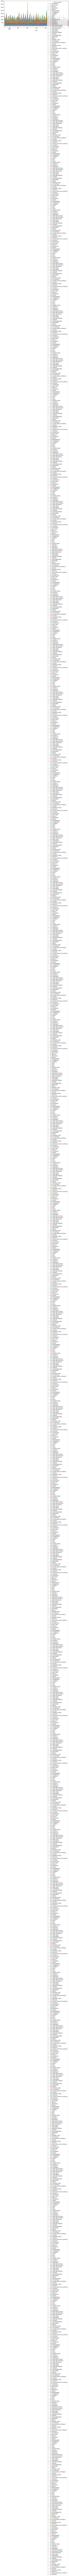

In [519]:
# resample data
store_sales_agg = store_sales2[['sales']].unstack(['store_nbr', 'family']).resample('D').sum()
store_sales_agg['sales'].plot(figsize=(12,5))

In [525]:
# ad_test(store_sales_agg.stack(['store_nbr', 'family'])['sales'])

In [ ]:
# ARIMA is not viable here with the amount of data and how slow my computer is - sounds like it will take off
# I also believe there is seasonality so we would need to use SARIMA model